In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pysindy as ps
import math
from math import pi

Variables:

In [2]:
def coefs_ecs(p_c):
    coefs = {
        'A': p_c['T']/p_c['m'],
        'B': (pi*p_c['rho']*p_c['cd0']*(p_c['d']**2))/(8*p_c['m']),
        'C': p_c['g'],
        'D': (1-pi*p_c['rho']*(p_c['d']**3)*p_c['cntp']/(16*p_c['m']))/(1+pi*p_c['rho']*(p_c['d']**3)*p_c['cnap']/(16*p_c['m'])),
        'E': (pi*p_c['rho']*(p_c['d']**2)*p_c['cna']/(16*p_c['m']))/(1+pi*p_c['rho']*(p_c['d']**3)*p_c['cnap']/(16*p_c['m'])),
        'F': (p_c['T'])/(p_c['m']+pi*p_c['rho']*(p_c['d']**3)*p_c['cnap']/(16)),
        'G': p_c['g']/(1+pi*p_c['rho']*(p_c['d']**3)*p_c['cnap']/(16*p_c['m'])),
        'H': (pi*p_c['rho']*(p_c['d']**3)*p_c['cma'])/(8*p_c['Iy']),
        'I': (pi*p_c['rho']*(p_c['d']**4)*p_c['cmtp'])/(16*p_c['Iy']),
        'J': (pi*p_c['rho']*(p_c['d']**4)*p_c['cmap'])/(16*p_c['Iy'])
    }
    return coefs

In [3]:
paso_tiempo=0.001
max_time = 30.0

#parametros fisicos del cohete:
param_cohe = {
    'T': 29160, #empuje
    'm': 77.4, #masa
    'rho': 1.225, #densidad
    'd': 0.14, #diametro
    'cntp': 67.934021, #cntheta'
    'cnap': 50.813892,#cn alfa'
    'cna': 0.415000,#cnalfa
    'Iy': 35.63,#inercia en el eje y
    'cma': -35.581600,#cm alfa
    'cmtp': 0,#60.934021,#cm theta'
    'cmap': 0,#-225.731250,#cm alfa'
    'cd0': 0.270000,#fallo en el pdf???????????????????? sip
    'g': 9.81, #gravedad
}

#coeficientes de las ecuaciones del cohete 2D:
coefs = coefs_ecs(param_cohe)

#valores iniciales:
inicial_values = {
    #'x': 1.,
    #'y': 1.,
    'vel': 50,
    'alfa': math.pi*2/45,
    'theta': math.pi*2/45, #40 grados
    'theta_dot': 0.0001 
}
 #x,y,v, alfa, theta, theta'

Las incógnitas son theta, alfa, V, theta prima y alfa prima. Ecuaciones a modelar:

In [4]:
def eqs(t_train, x0_train, a=coefs['A'], b=coefs['B'], c=coefs['C'], d=coefs['D'], e=coefs['E'], f=coefs['F'], 
        g=coefs['G'],h=coefs['H'], i=coefs['I'], jota=coefs['J']):
    
    alfa0, theta0, u0, v0 = x0_train #x0, y0, 
    vel_dot = a*math.cos(alfa0) - b*v0**2 - c*math.sin(theta0-alfa0)
    alfa_dot = d*u0 - e*v0*alfa0 - f*math.sin(alfa0)*1/v0 + g*math.cos(theta0 - alfa0)*1/v0
    theta_dot_dot = h*alfa0*v0**2 + i*v0*u0 + jota*v0*alfa_dot
    
    #x_dot = v0*math.cos(theta0-alfa0)
    #y_dot = v0*math.sin(theta0-alfa0)
    
    theta_dot = u0
    return alfa_dot, theta_dot, theta_dot_dot, vel_dot  #x_dot, y_dot, 

In [11]:
#x0_train = [x, y, v, alfa, theta, theta']
def calculate_data(t_max, dt, coefs, inicial_values):
    
    t_train = np.arange(0.0, t_max, dt)
    a=coefs['A']
    b=coefs['B']
    c=coefs['C']
    d=coefs['D']
    e=coefs['E']
    f=coefs['F']
    g=coefs['G']
    h=coefs['H']
    i=coefs['I']
    jota=coefs['J']
    x0_train=[
        #inicial_values['x'],
        #inicial_values['y'],
         
        inicial_values['alfa'],
        inicial_values['theta'],
        inicial_values['theta_dot'],
        inicial_values['vel'],
    ]
    
    #sol = np.ones((t_train.size, 5))
    print(t_train[0], t_train[-1])
    
    x_sol = solve_ivp(eqs, (t_train[0], t_train[-1]), x0_train, args=(a, b, c, d, e, f, g, h, i, jota), t_eval=t_train) 
    #[x, y, v, alfa, theta, theta']
    print(x_sol)
    
    x_dot_train_measured = np.ones((t_train.size, 4)) #contiene, x',y',v',alfa',theta''
    
   
    fig = plt.figure()
    #ax = fig.gca(projection='2d')

    #plt.plot(x_sol.t, x_sol.y.T[:, 0], lw=0.5)
    #plt.xlabel("tiempo")
    #plt.ylabel("posicion en x")
    #plt.title("Trayectoria en x")

    #plt.show()
    
    #fig = plt.figure()
    #ax = fig.gca(projection='2d')

    #plt.plot(x_sol.t, x_sol.y.T[:, 1], lw=0.5)
    #plt.xlabel("tiempo")
    #plt.ylabel("posicion y")
    #plt.title("Trayectoria en y")

    #plt.show()
    
    #fig = plt.figure()
    #ax = fig.gca(projection='2d')

    #plt.plot(x_sol.y.T[:, 0], x_sol.y.T[:, 1], lw=0.5)
    #plt.xlabel("tiempo")
    #plt.ylabel("posicion y")
    #plt.title("posicion x frente a y")

    #plt.show()
   
    plt.plot(x_sol.t, x_sol.y.T[:, 0:2])
    plt.legend(["alfa", "theta"])
    plt.show()
    
    fig = plt.figure()
    plt.plot(x_sol.t, x_sol.y.T[:, 3])
    plt.legend(["alfa"])
    plt.show()
    print(t_train.size, x_sol.y.T.shape)
    for i in range(t_train.size):
        x_dot_train_measured[i, :] = eqs(t_train, x_sol.y.T[i, :], a,b,c,d,f,g,h,i,jota)

    
    
    
    return x_sol.y.T, x_dot_train_measured

Defino mi propia librería de funciones:

In [6]:
def custom_library(poly_order=2):
    library_functions = [
        #lambda theta, alfa : np.cos(theta-alfa),
        #lambda theta, alfa : np.sin(theta-alfa),
        lambda alfa : np.sin(alfa),
        lambda alfa : np.cos(alfa),
        #lambda v: v**2,
        lambda v, alfa: np.sin(alfa)/v 
    ]
    library_function_names = [
        #lambda theta, alfa : 'cos(' + theta + '-' + alfa +')',
        #lambda theta, alfa : 'sen(' + theta + '-' + alfa +')',
        lambda alfa : 'sen('  + alfa +')',
        lambda alfa : 'cos('  + alfa +')',
        #lambda v: v + '^2',
        lambda v, alfa: 'sen(' + alfa + ')/' + v 
    ]
    library = ps.CustomLibrary(
                        library_functions=library_functions, 
                        function_names=library_function_names) #+ ps.PolynomialLibrary(degree=poly_order)
    return library

In [7]:
def custom_library2(poly_order=2):
    library_functions = [
        #lambda theta, alfa, v : v*np.cos(theta-alfa),
        lambda theta, alfa : np.cos(theta-alfa),
        lambda theta, alfa, v : np.cos(theta-alfa)*1./v,
        lambda theta, alfa : np.sin(theta-alfa),
        #lambda theta, alfa, v : v*np.sin(theta-alfa),
        lambda alfa : np.sin(alfa),
        lambda alfa, v : np.sin(alfa)*1./v,
        lambda alfa : np.cos(alfa),
        #lambda v: 1./v,
        lambda v, alfa: alfa*v**2,
        lambda v, alfa: v*alfa**2,
        lambda v, alfa: alfa*v,
        lambda v: v**2,
        lambda theta: theta,
        
        
    ]
    library_function_names = [
        lambda theta, alfa : 'cos(' + theta + '-' + alfa +')',
        #lambda theta, alfa, v : v + '*' + 'cos(' + theta + '-' + alfa +')',
        lambda theta, alfa, v : 'cos(' + theta + '-' + alfa +')/' + v,
        lambda theta, alfa : 'sen(' + theta + '-' + alfa +')',
        #lambda theta, alfa, v : v + '*' + 'sen(' + theta + '-' + alfa +')',
        lambda alfa : 'sen('  + alfa +')',
        lambda alfa, v : 'sen('  + alfa +')/' + v,
        lambda alfa : 'cos('  + alfa +')',
        #lambda v :  '1/' + v,
        lambda v, alfa: alfa+'*'+v+'^2',
        lambda v, alfa: v+'*'+alfa+'^2',
        lambda v, alfa: alfa+'*'+v,
        lambda v: v+'^2',
        lambda theta: theta,
        
        
    ]
    library = ps.CustomLibrary(
                        library_functions=library_functions, 
                        function_names=library_function_names, interaction_only=True) 
    return library

In [9]:
def sindy_model(x_train, dt, x_dot_train=None, threshold = 0.2, terminos_ctes=False, varias_trayectorias=False):
    # Fit the model, me creo el modelo dinámico 

    #pysindy calcula las ecs que gobierna el movimiento
    model = ps.SINDy(
        differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        optimizer=ps.SR3(threshold=0.05, max_iter=5000),
        feature_library=custom_library2(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['v', 'alfa', 'theta', "theta'"], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

    #la doc dice que en t hay que poner el time step
    model.fit(x_train, t=dt, x_dot=x_dot_train, quiet=True, multiple_trajectories=varias_trayectorias)

    #print(model.equations(precision=52))
    model.print(precision=4)
    #print(model.coefficients())
    return model

Genero los datos:

0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


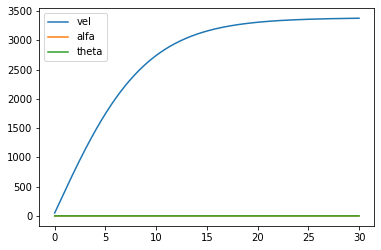

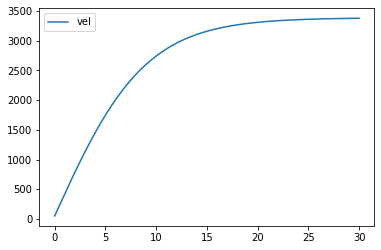

30000 (30000, 4)
[[ 5.00000000e+01  1.39626340e-01  1.39626340e-01  1.00000000e-04]
 [ 5.03730129e+01  1.38780259e-01  1.39626209e-01 -3.62177417e-04]
 [ 5.07460602e+01  1.37946151e-01  1.39625614e-01 -8.28420197e-04]
 ...
 [ 3.37922174e+03  6.80518475e-05 -8.20032158e-02  3.25032143e-02]
 [ 3.37922370e+03  1.02815887e-04 -8.19712946e-02  3.12098891e-02]
 [ 3.37922566e+03  1.36019590e-04 -8.19409286e-02  2.94070626e-02]]
(30000, 4)


In [9]:
x_train, x_dot_train = calculate_data(max_time, paso_tiempo, coefs, inicial_values)
print(x_train)
print(x_train.shape)



In [10]:
model = sindy_model(x_train, paso_tiempo)#, x_dot_train=x_dot_train)

v' = -45948092.9567 cos(alfa-theta) + 203423.5166 cos(alfa-theta') + 171441.8184 cos(theta-theta') + -4536539.7427 sen(alfa-theta) + -8251.1569 sen(alfa-theta') + 8513.4830 sen(theta-theta') + 47296097.8919 cos(alfa) + 3969857.7411 cos(theta) + -293308.9788 cos(theta') + 45320.5281 theta*alfa^2 + -281143.4756 theta'*alfa^2 + -2121.8018 theta'*theta^2 + 22984141.0191 theta*alfa + -101035.8633 theta'*alfa + -85214.8970 theta'*theta + -5399161.1245 1 + 4539271.6290 alfa + -4539447.1221 theta + 276.2007 theta' + 731881.2804 alfa^2 + 22984141.0191 alfa theta + -101035.8634 alfa theta' + -20920839.1326 theta^2 + -85214.8983 theta theta' + 40567.8490 theta'^2
alfa' = -204.0024 cos(alfa-theta') + 66.5272 cos(theta-theta') + -4.1886 sen(alfa-theta) + 3.7979 sen(alfa-theta') + -3.6669 sen(theta-theta') + -29189.7622 cos(alfa) + -2949.2183 cos(theta) + 124.2738 cos(theta') + -475.0698 theta*alfa^2 + -49.9072 theta'*alfa^2 + 10.1781 theta'*theta^2 + -7.6711 theta*alfa + 100.9406 theta'*alfa + -32.

In [11]:
estimator = ps.deeptime.SINDyEstimator(t_default=paso_tiempo)
estimator.fit(x_train);
model = estimator.fetch_model()

# Compare SINDy-predicted derivatives with finite difference derivatives
#print('Model score: %f' % model.score(x_test, t=paso_tiempo))
model.print()
#puede que las cosas no estén saliendo bien porque en la tercera ecuación theta'' depende de alfa' y no de alfa?
# en el resto de ecuaciones no pasa

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77557e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77557e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77557e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77557e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


x0' = 211.539 1 + -1868.338 x1 + 3915.238 x2 + 37.907 x3 + 36069.902 x1^2 + -54556.856 x1 x2 + 2166.159 x1 x3 + 10685.341 x2^2 + 2425.088 x2 x3 + 387.031 x3^2
x1' = -2.156 x1 + 0.989 x3 + -39.747 x1^2 + 15.161 x1 x2 + -0.152 x1 x3 + 1.196 x2^2 + -0.631 x2 x3
x2' = 1.000 x3
x3' = 1.356 1 + 1815.532 x1 + 55.194 x2 + -3.898 x0 x1 + 912.757 x1^2 + -13060.398 x1 x2 + 404.469 x1 x3 + 540.338 x2^2 + 6.227 x2 x3 + -29.049 x3^2


In [12]:
estimator = ps.deeptime.SINDyEstimator(
    optimizer=ps.SR3(threshold=0.05, max_iter=10000, tol=1e-10,), #SR3 consigue sacar la v de sen y cos
    feature_library=custom_library2().fit(x_train),
    #ps.PolynomialLibrary(degree=2)+ps.FourierLibrary()#custom_library2(),
    feature_names=['v', 'alfa', 'theta', "theta'"],
    
)
estimator.fit(x_train, t=paso_tiempo)

model = estimator.fetch_model()
model.print()

v' = -45947794.991 cos(alfa-theta) + 203425.007 cos(alfa-theta') + 171441.718 cos(theta-theta') + -4536539.316 sen(alfa-theta) + -8251.161 sen(alfa-theta') + 8513.481 sen(theta-theta') + 47295427.341 cos(alfa) + 3969584.271 cos(theta) + -293310.381 cos(theta') + 45325.992 theta*alfa^2 + -281143.892 theta'*alfa^2 + -2121.816 theta'*theta^2 + 22983992.092 theta*alfa + -101036.608 theta'*alfa + -85214.847 theta'*theta + -5398515.057 1 + 4539271.205 alfa + -4539446.693 theta + 276.194 theta' + 731695.539 alfa^2 + 22983992.092 alfa theta + -101036.608 alfa theta' + -20920826.938 theta^2 + -85214.848 theta theta' + 40567.843 theta'^2
alfa' = -281.125 cos(alfa-theta') + 81.235 cos(theta-theta') + -0.869 sen(alfa-theta') + 0.726 sen(theta-theta') + -17928.456 cos(alfa) + -4317.632 cos(theta) + 218.001 cos(theta') + -626.671 theta*alfa^2 + -38.356 theta'*alfa^2 + 9.164 theta'*theta^2 + 139.538 theta'*alfa + -40.247 theta'*theta + 22227.981 1 + -0.606 theta + 0.859 theta' + -9040.058 alfa^2 + 13

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/sr3.py:265: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


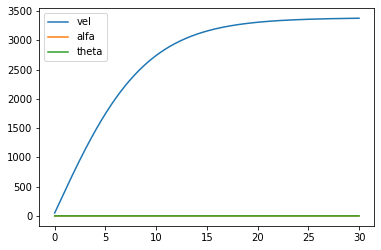

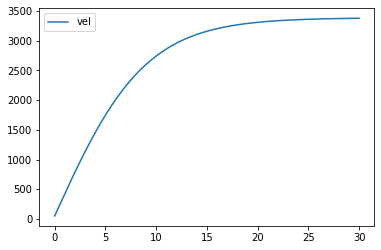

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


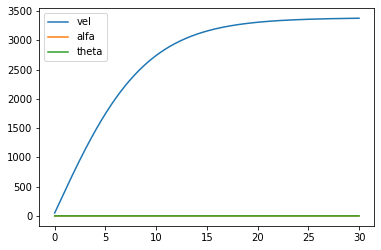

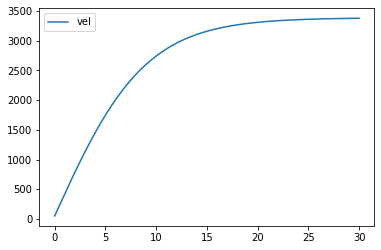

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


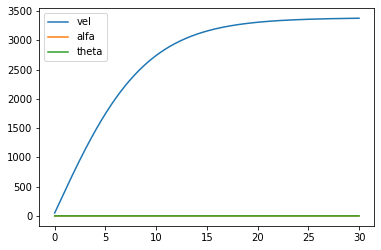

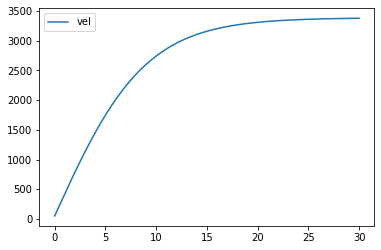

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


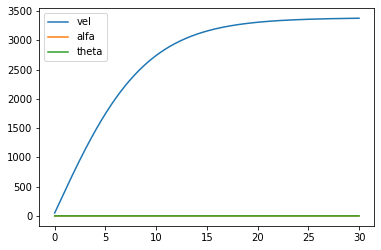

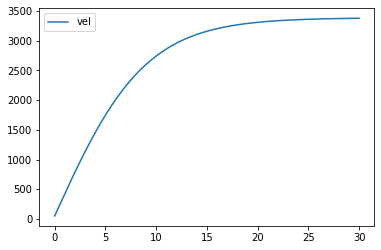

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


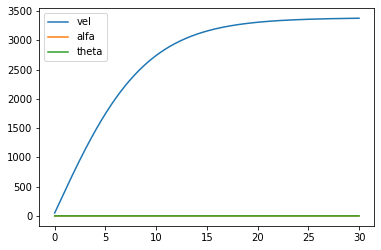

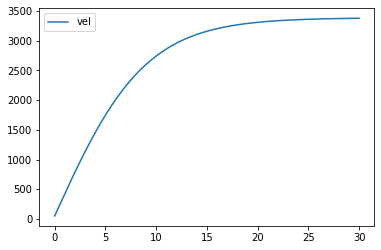

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


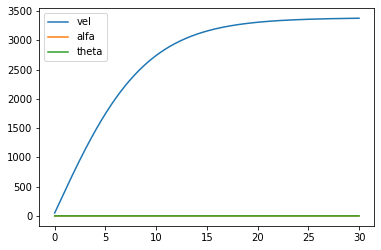

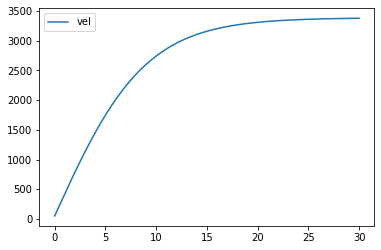

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


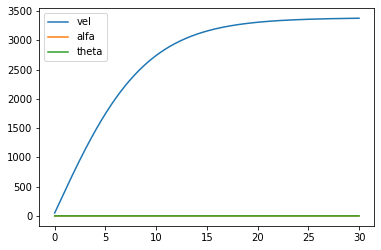

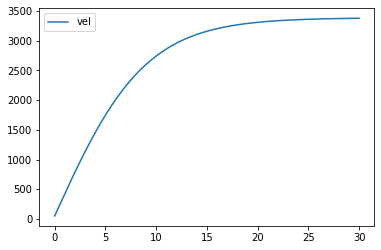

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


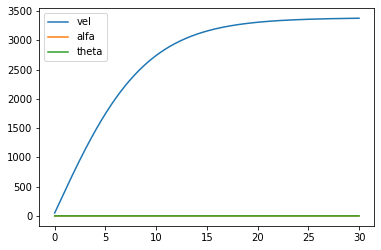

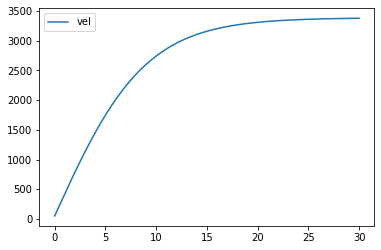

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


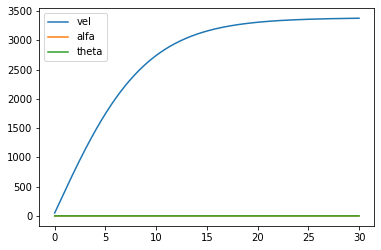

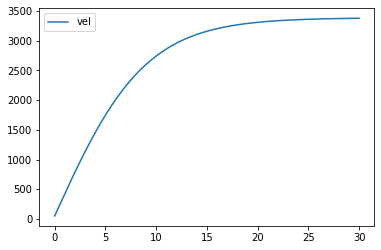

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


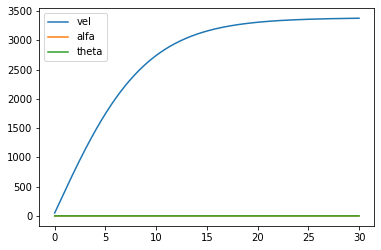

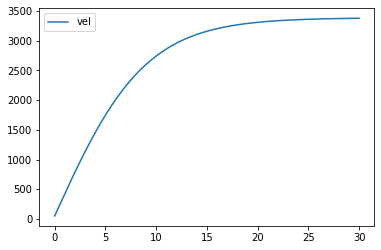

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


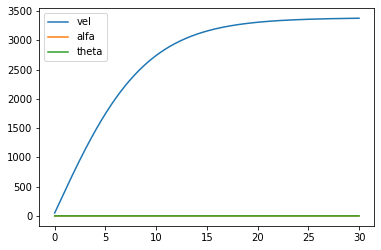

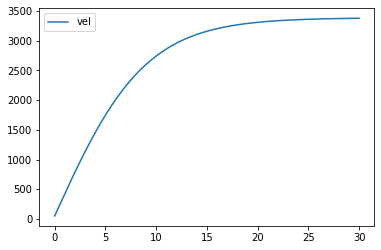

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


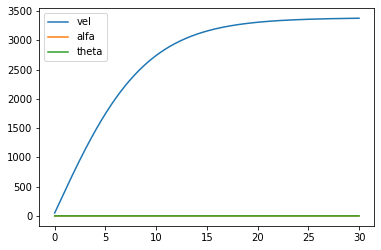

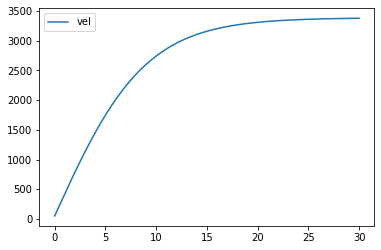

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


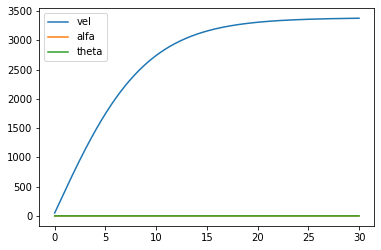

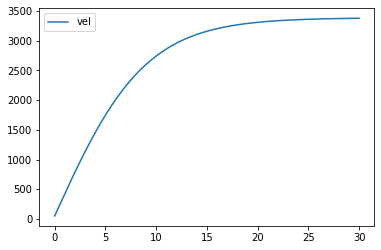

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


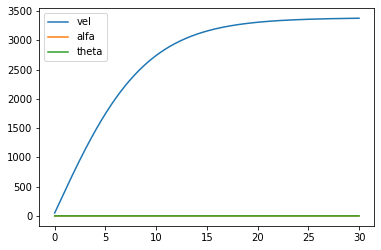

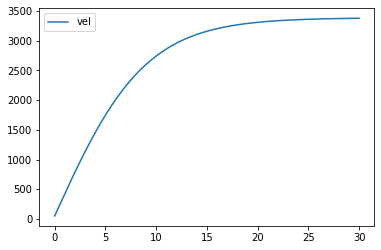

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


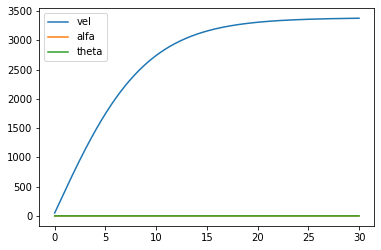

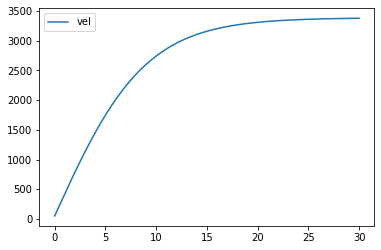

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


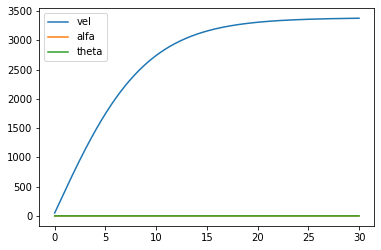

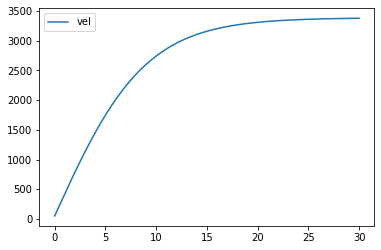

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


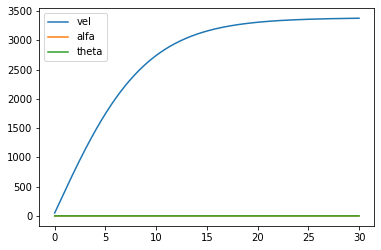

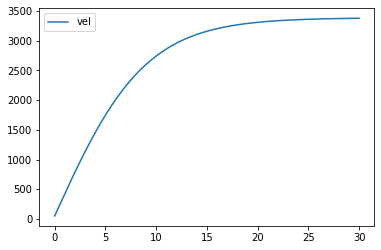

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


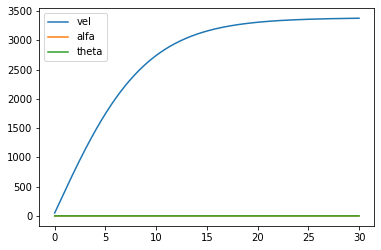

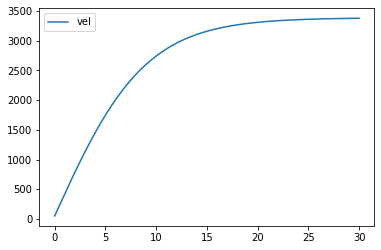

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


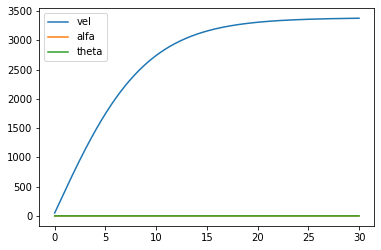

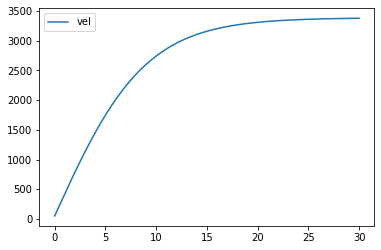

30000 (30000, 4)
0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03],
       [ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02]])
 y_events: None


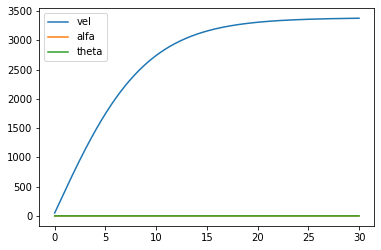

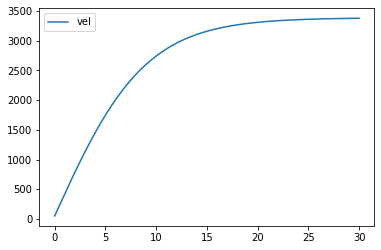

30000 (30000, 4)


In [13]:
n_trajectories = 20
x0s = np.array([40, math.sin(math.radians(10)), math.sin(math.radians(10)), math.sin(math.radians(10))]) * (
    np.random.rand(n_trajectories, 4) - 0.05
) + np.array([2, 0.01, 0.01, 0.01])
x_train_multi = []
x_dot_train_multi = []
for i in range(n_trajectories):
    x_train, x_dot_train = calculate_data(max_time, paso_tiempo, coefs, inicial_values)
    x_train_multi.append(x_train)
    x_dot_train_multi.append(x_dot_train)

In [14]:
lib = ps.IdentityLibrary().fit(x_train)+custom_library2().fit(x_train)


estimator = ps.deeptime.SINDyEstimator(
    optimizer=ps.SR3(threshold=0.05, max_iter=10000, tol=1e-10,), #SR3 consigue sacar la v de sen y cos
    feature_library=lib,
    
    #custom_library2(),#ps.PolynomialLibrary(degree=2)+ps.FourierLibrary(),#
    feature_names=['v', 'alfa', 'theta', "theta'"],
    
)
estimator.fit(x_train, t=paso_tiempo, multiple_trajectories=False)

model = estimator.fetch_model()
model.print()

v' = 2269635.602 alfa + -2269723.344 theta + 138.099 theta' + -45947795.211 cos(alfa-theta) + 203425.006 cos(alfa-theta') + 171441.718 cos(theta-theta') + -4536539.316 sen(alfa-theta) + -8251.161 sen(alfa-theta') + 8513.481 sen(theta-theta') + 47295427.746 cos(alfa) + 3969584.464 cos(theta) + -293310.380 cos(theta') + 45325.988 theta*alfa^2 + -281143.892 theta'*alfa^2 + -2121.816 theta'*theta^2 + 22983992.202 theta*alfa + -101036.607 theta'*alfa + -85214.846 theta'*theta + -5398515.435 1 + 2269635.604 alfa + -2269723.350 theta + 138.095 theta' + 731695.631 alfa^2 + 22983992.202 alfa theta + -101036.607 alfa theta' + -20920826.951 theta^2 + -85214.848 theta theta' + 40567.843 theta'^2
alfa' = -0.136 theta + 0.254 theta' + -294.098 cos(alfa-theta') + 83.345 cos(theta-theta') + -0.894 sen(alfa-theta') + 0.396 sen(theta-theta') + -18386.365 cos(alfa) + -4655.431 cos(theta) + 210.690 cos(theta') + -607.718 theta*alfa^2 + -36.869 theta'*alfa^2 + 9.072 theta'*theta^2 + 145.994 theta'*alfa + -

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/sr3.py:265: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


In [15]:
lib = ps.IdentityLibrary().fit(x_train)
lib.transform(x_train)

array([[ 5.00000000e+01,  1.39626340e-01,  1.39626340e-01,
         1.00000000e-04],
       [ 5.03730129e+01,  1.38780259e-01,  1.39626209e-01,
        -3.62177417e-04],
       [ 5.07460602e+01,  1.37946151e-01,  1.39625614e-01,
        -8.28420197e-04],
       ...,
       [ 3.37922174e+03,  6.80518475e-05, -8.20032158e-02,
         3.25032143e-02],
       [ 3.37922370e+03,  1.02815887e-04, -8.19712946e-02,
         3.12098891e-02],
       [ 3.37922566e+03,  1.36019590e-04, -8.19409286e-02,
         2.94070626e-02]])

In [16]:
estimator = ps.deeptime.SINDyEstimator(
    optimizer=ps.SR3(threshold=0.05, max_iter=10000, tol=1e-10,), #SR3 consigue sacar la v de sen y cos
    feature_library=ps.PolynomialLibrary(degree=2),
    
    #custom_library2(),#ps.PolynomialLibrary(degree=2)+ps.FourierLibrary(),#
    feature_names=['x', 'y', 'v'],
    
)
estimator.fit(x_train[:, 0:3], t=paso_tiempo, multiple_trajectories=False)

model = estimator.fetch_model()
model.print()

x' = 222.585 1 + -1297.095 y + 3963.711 v + 53084.794 y^2 + -73231.442 y v + 9010.086 v^2
y' = -0.001 1 + -0.607 y + -0.432 v + -21.087 y^2 + -6.784 v^2
v' = -0.009 1 + 1.073 y + -0.799 v + 10.636 y^2 + 3.002 y v + -11.080 v^2


/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/sr3.py:265: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


In [17]:
a = np.arange(0.0, max_time, paso_tiempo)
print(a.shape)

(30000,)


# Casos:

## Caso 1: La piedra

En este caso voy a simular la dinámica del punto, movimiento de una piedra, solo peso y resistencia. Empuje y sustentación son nulos

In [18]:
#en este caso como no hay sust todos los cn son nulos al igual que los momentos
paso_tiempo=0.001
max_time = 100.0

#parametros fisicos del cohete:
param_cohe = {
    'T': 0, #empuje
    'm': 1, #masa
    'rho': 1.225, #densidad
    'd': 0.2, #diametro
    'cntp': 0, #cntheta'
    'cnap': 0,#cn alfa'
    'cna': 0,#cnalfa
    'Iy': 2/5*1*0.1**2,#inercia en el eje y de una esfera
    'cma': 0,#cm alfa
    'cmtp': 0,#60.934021,#cm theta'
    'cmap': 0,#-225.731250,#cm alfa'
    'cd0': 0.270000,
    'g': 9.81, #gravedad
}

#coeficientes de las ecuaciones del cohete 2D:
coefs = coefs_ecs(param_cohe)

#valores iniciales:
inicial_values = {
    #'x': 1.,
    #'y': 1.,
    'vel': 25,
    'alfa': 0.0000001,
    'theta': 0.000001, 
    'theta_dot': 0.000001 
}
 #x,y,v, alfa, theta, theta'

0.0 99.999
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 134
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 9.9997e+01, 9.9998e+01,
       9.9999e+01])
 t_events: None
        y: array([[2.50000000e+01, 2.49967552e+01, 2.49935151e+01, ...,
        4.34443586e+01, 4.34443627e+01, 4.34443668e+01],
       [1.00000000e-07, 3.92526463e-04, 7.85003773e-04, ...,
        1.57089732e+00, 1.57089732e+00, 1.57089733e+00],
       [1.00000000e-06, 1.00100000e-06, 1.00200000e-06, ...,
        1.00997000e-04, 1.00998000e-04, 1.00999000e-04],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        1.00000000e-06, 1.00000000e-06, 1.00000000e-06]])
 y_events: None


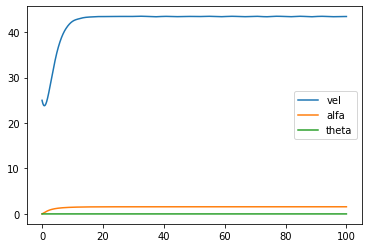

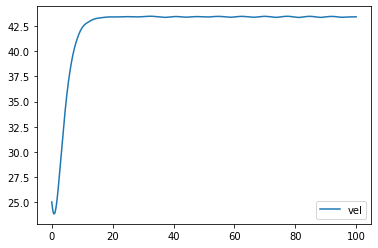

100000 (100000, 4)


In [19]:
#genero los datos:
x_train, x_dot_train = calculate_data(max_time, paso_tiempo, coefs, inicial_values)


In [20]:
print(x_train)
print(x_train.shape)
print(x_dot_train)
print(x_dot_train.shape)

[[2.50000000e+01 1.00000000e-07 1.00000000e-06 1.00000000e-06]
 [2.49967552e+01 3.92526463e-04 1.00100000e-06 1.00000000e-06]
 [2.49935151e+01 7.85003773e-04 1.00200000e-06 1.00000000e-06]
 ...
 [4.34443586e+01 1.57089732e+00 1.00997000e-04 1.00000000e-06]
 [4.34443627e+01 1.57089732e+00 1.00998000e-04 1.00000000e-06]
 [4.34443668e+01 1.57089733e+00 1.00999000e-04 1.00000000e-06]]
(100000, 4)
[[-3.24713936e+00  9.60760000e-07  1.00000000e-06  0.00000000e+00]
 [-3.24244682e+00 -1.53047374e-04  1.00000000e-06  2.45265360e-01]
 [-3.23775511e+00 -3.07115373e-04  1.00000000e-06  9.80745716e-01]
 ...
 [ 4.12148410e-03 -2.25805072e-01  1.00000000e-06  2.96484197e+08]
 [ 4.11962767e-03 -2.25805051e-01  1.00000000e-06  2.96487218e+08]
 [ 4.11776962e-03 -2.25805029e-01  1.00000000e-06  2.96490239e+08]]
(100000, 4)


In [21]:
#intento predecir con sindy:
model = sindy_model(x_train, paso_tiempo)
#si pongo de valor inicial de la theta, alfa y theta' da error porque hace 1/0-------> arreglo?

v' = 198.7771 cos(v-theta') + -1230126.3373 cos(theta-theta') + 0.1564 sen(v-alfa) + -0.0355 sen(v-theta) + 2.5080 sen(theta)/theta' + -198.6537 cos(v) + -1230163.2089 cos(theta) + 1230137.9567 cos(theta') + 1481.6314 theta*v^2 + 5.2337 alfa*v + -61050.7446 theta*v + 1230138.0584 1 + 0.8942 v + 5.2076 alfa + -0.0201 v^2 + -4.9731 v alfa + -61050.7445 v theta + -5.3708 alfa^2
alfa' = 69599311990.5845 cos(theta-theta') + -69623496606.4507 cos(theta) + 11903751.1428 cos(theta') + -37.6676 theta*v^2 + 12280864.7970 1
theta' = 0.0000
theta'' = 0.0000


In [22]:
np.any(np.isnan(x_dot_train))

False

In [23]:
np.all(np.isfinite(x_dot_train))

True

In [24]:
np.any(x_dot_train > np.finfo(np.float64).max)

False

In [25]:
np.isnan(x_train).sum()

0

In [26]:
x_train[:, 3].min()

1e-06

In [27]:
a

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])

## Pruebas con trayectoria proporcionada por matlab

In [12]:
var = np.loadtxt('vars.csv', delimiter=",")
der = np.loadtxt('derivadas.csv', delimiter=",")

var2 = np.loadtxt('vars2.csv', delimiter=",")
der2 = np.loadtxt('ders2.csv', delimiter=",")

var3 = np.loadtxt('vars3.csv', delimiter=",")
der3 = np.loadtxt('ders3.csv', delimiter=",")

#altitud=0.5m, latitud=5m, long=10m, roll=0, pitch=20
var4 = np.loadtxt('vars4.csv', delimiter=",")
der4 = np.loadtxt('ders4.csv', delimiter=",")

In [29]:
print(var.shape)
print(var2.shape)
print(var3.shape)
print(var4.shape)

print('\n')
print(der.shape)
print(der2.shape)
print(der3.shape)
print(der4.shape)


(7, 3427)
(7, 4788)
(7, 4788)
(7, 12830)


(7, 3427)
(7, 4788)
(7, 4788)
(7, 12830)


In [30]:
var_tot = np.concatenate((var.T[1:, 3:7], var2.T[1:, 3:7], var3.T[1:, 3:7], var4.T[1:, 3:7]))
der_tot = np.concatenate((der.T[1:, 3:7], der2.T[1:, 3:7], der3.T[1:, 3:7], der4.T[1:, 3:7]))
print(var_tot.shape, der_tot.shape)
var_tot = [var.T[1:, 3:7], var2.T[1:, 3:7], var3.T[1:, 3:7], var4.T[1:, 3:7]]
der_tot = [der.T[1:, 3:7], der2.T[1:, 3:7], der3.T[1:, 3:7], der4.T[1:, 3:7]]

(25829, 4) (25829, 4)


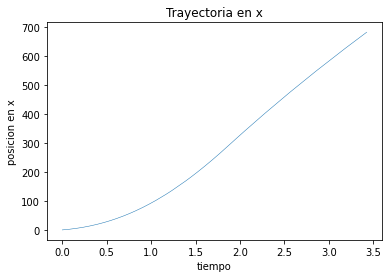

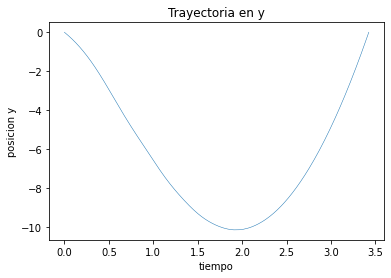

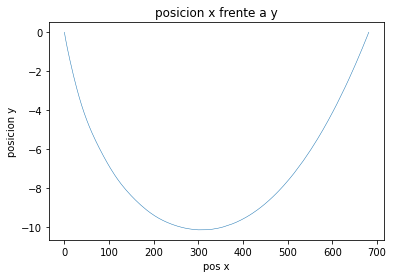

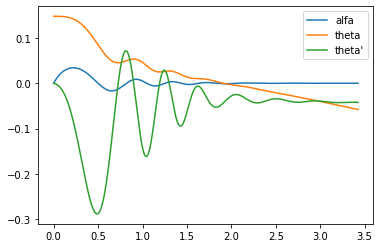

In [31]:
fig = plt.figure()
    #ax = fig.gca(projection='2d')

plt.plot(var.T[:, 0], var.T[:, 1], lw=0.5)
plt.xlabel("tiempo")
plt.ylabel("posicion en x")
plt.title("Trayectoria en x")

plt.show()
    
fig = plt.figure()
    #ax = fig.gca(projection='2d')

plt.plot(var.T[:, 0], var.T[:, 2], lw=0.5)
plt.xlabel("tiempo")
plt.ylabel("posicion y")
plt.title("Trayectoria en y")

plt.show()
    
fig = plt.figure()
    #ax = fig.gca(projection='2d')

plt.plot(var.T[:, 1], var.T[:, 2], lw=0.5)
plt.xlabel("pos x")
plt.ylabel("posicion y")
plt.title("posicion x frente a y")

plt.show()
   
plt.plot(var.T[:, 0], var.T[:, 4:7])
plt.legend(["alfa","theta", "theta'"])
plt.show()

In [32]:
var.T[1, 0:10]

array([ 1.0000e-03,  2.4782e-02, -3.7046e-03,  2.5116e+01,  3.8584e-04,
        1.4858e-01, -3.3290e-05])

In [33]:
a= var.T[0:100, 0:7]
#tiempo, x, y, vel, alfa, theta, theta'
print(np.any(np.isnan(a)), np.all(np.isfinite(a)))

False True


In [34]:
b = der.T[0:100, 0:7]
print(np.any(np.isnan(b)), np.all(np.isfinite(b)))

False True


Tengo que transponer porque las filas es la caracteristica 

In [35]:
model = sindy_model(var.T[1:, 3:7], 0.001) #, der.T[1:, 3:7]##solo le paso los angulos, no la posicion
#las derivadas apenas están dando información

v' = -13.7652 cos(v-alfa) + 7.4202 cos(v-theta) + 1.5500 cos(v-theta') + 700715000.3382 cos(alfa-theta) + 1596626.8583 cos(alfa-theta') + -294438.7416 cos(theta-theta') + 0.0424 cos(v-alfa)/theta + -0.0678 cos(v-alfa)/theta' + 0.0677 cos(v-theta)/theta' + -36.0953 sen(v-alfa) + 30.3989 sen(v-theta) + 5.7678 sen(v-theta') + -11182123.8681 sen(alfa-theta) + -377929.5611 sen(alfa-theta') + 279466.2277 sen(theta-theta') + -7.4421 sen(alfa)/theta + -0.0800 sen(alfa)/theta' + 0.0199 sen(theta)/theta' + 5.6742 cos(v) + 2227215060.3963 cos(alfa) + 25421851.7553 cos(theta) + -1303197.0356 cos(theta') + -3.0052 alfa*v^2 + 3.0892 theta*v^2 + -0.3124 theta'*v^2 + 9881379.5856 theta*alfa^2 + -1064885.8414 theta'*alfa^2 + -346608.6036 theta'*theta^2 + 37728.0050 alfa*v + -69687.5587 theta*v + -147474.7730 theta'*v + -349286199.3488 theta*alfa + -758774.7753 theta'*alfa + 126689.5954 theta'*theta + -2953328148.3215 1 + -156.3088 v + 11533936.7660 alfa + -11486352.6599 theta + -111246.0805 theta' + 0.

In [36]:
#var_tot_list = var_tot.tolist()
#der_tot_list = der_tot.tolist()

#print(der_tot_list[1:10])
model = sindy_model(var_tot, .001, varias_trayectorias=True)#der_tot



v' = -8.8111 cos(v-alfa) + -0.7985 cos(v-theta) + 0.7125 cos(v-theta') + 990369.4245 cos(alfa-theta) + -1790309.8072 cos(alfa-theta') + -727802.0170 cos(theta-theta') + 0.0078 cos(v-alfa)/theta' + -0.0101 cos(v-theta)/theta' + -4.9226 sen(v-alfa) + 1.8291 sen(v-theta) + 3.3174 sen(v-theta') + -46667.1575 sen(alfa-theta) + -475931.2179 sen(alfa-theta') + -138450.8740 sen(theta-theta') + -0.2472 sen(alfa)/theta + 0.0135 sen(theta)/theta' + 8.5111 cos(v) + -4434318276.2836 cos(alfa) + 15378.9965 cos(theta) + -2287854.6295 cos(theta') + -0.5857 alfa*v^2 + 0.1399 theta'*v^2 + -1346943.8204 theta*alfa^2 + 205280.3578 theta'*alfa^2 + -71314.1594 theta'*theta^2 + 650.4584 alfa*v + 106360.8504 theta*v + -19663.7465 theta'*v + -492565.6683 theta*alfa + 903424.1564 theta'*alfa + 379958.6190 theta'*theta + 4438118488.6594 1 + -0.0270 v + 505222.3663 alfa + 93369.1435 theta + -607879.2276 theta' + -435.8679 v alfa + -106361.2312 v theta + 19602.1591 v theta' + -2216570610.8988 alfa^2 + -492632.1694

## Simplificación con polinomios

In [37]:
#represento para ver cómo de buena es la aproximación
#recibe la matriz real sobre la que sindy ha aprendido y el vector de tiempos
def plot_aprox_real(x_or, t_or, model, cond_inic):
    x_test_sim = model.simulate(cond_inic, t_or)
    print('Model score: %f' % model.score(x_test_sim, t=t_or[0]))
    
    fig, axs = plt.subplots(x_or.shape[1], 1, sharex=True, figsize=(7, 9))
    for i in range(x_or.shape[1]):
        axs[i].plot(t_or, x_or[:, i], 'k', label='true simulation')
        axs[i].plot(t_or, x_test_sim[:, i], 'r--', label='model simulation')
        axs[i].legend()
        axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))
    return None


### Pruebo con el modelo de sindy:

In [38]:
def sindy_model_2(x_train, dt, grado=2, terminos_ctes=False, varias_trayectorias=False):
    #pysindy calcula las ecs que gobierna el movimiento
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=0.2, normalize=True,  fit_intercept=terminos_ctes),
        feature_library=ps.PolynomialLibrary(degree=grado, interaction_only=False),#ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,

        feature_names=['x', 'y', 'v'], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

    #la doc dice que en t hay que poner el time step
    model.fit(x_train, t=dt, quiet=True, multiple_trajectories=varias_trayectorias)

    #print(model.equations(precision=52))
    model.print()
    print(model.coefficients())
    return model

In [39]:
model2 = sindy_model_2(var.T[1:, 1:4], 0.001, grado=3)

x' = -0.378 1 + 1.001 v
y' = 0.000
v' = 160.880 1 + -0.435 v + 12.133 y^2 + 0.305 y v + 0.424 y^3
[[ -0.378227     0.           0.           1.00116877   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [160.87963678   0.           0.          -0.43506275   0.
    0.           0.          12.13327599   0.30468008   0.
    0.           0.           0.           0.           0.
    0.           0.42358793   0.           0.           0.        ]]


Model score: 0.666667


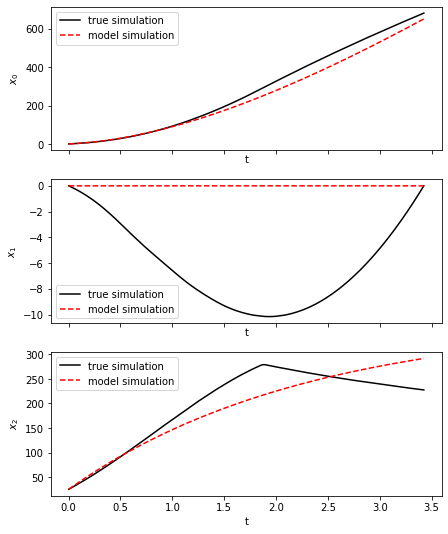

In [40]:
plot_aprox_real(var.T[1:, 1:4], var.T[1:, 0], model2, var.T[1, 1:4])
#simulacion malisima, en especial con la y

### Ahora pruebo con el estimador de sindy deeptime:

#### Prueba 1: Pruebo con condiciones iniciles que se encuentran en la matriz de entrenamiento y pruebo con valores extraños

In [41]:
def sindy_deeptime(lib, x_train, names, paso_tiempo=0.001):
    estimator = ps.deeptime.SINDyEstimator(
        optimizer=ps.SR3(threshold=0.05, max_iter=10000, tol=1e-10), #SR3 consigue sacar la v de sen y cos
        differentiation_method = ps.FiniteDifference(),
        feature_library=lib,
        #ps.PolynomialLibrary(degree=2)+ps.FourierLibrary()#custom_library2(),
        feature_names=names,

    )
    estimator.fit(x_train, t=paso_tiempo)

    model = estimator.fetch_model()
    model.print()
    #print(model.coefficients())
    return model


/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/sr3.py:265: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


x' = 0.095 1 + 0.002 x + -0.221 y + 0.987 v + -0.009 y^2 + -0.001 y v
y' = -0.424 1 + 0.010 x + -0.033 y + -0.117 v + 0.004 x y + 0.059 y^2 + -0.013 y v + 0.004 y^3
v' = 1492.674 1 + 102.129 x + -1749.071 y + -81.290 v + 0.030 x^2 + -19.142 x y + -0.783 x v + 569.290 y^2 + 59.070 y v + 1.056 v^2 + 0.022 x^2 y + -0.756 x y^2 + -0.039 x y v + 8.821 y^3 + -0.401 y^2 v + -0.043 y v^2
Model score: 1.000000


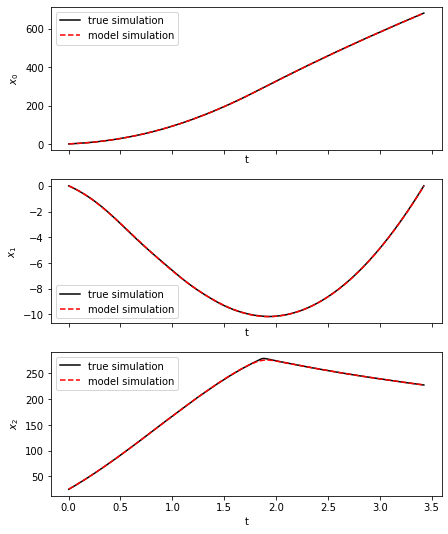

In [42]:
#pruebo con valores que ya estaban en la matriz de entrenamiento:
lib = ps.PolynomialLibrary(degree=3)
model = sindy_deeptime(lib, var.T[1:, 1:4], ['x', 'y', 'v'])
plot_aprox_real(var.T[1:, 1:4], var.T[1:, 0], model, var.T[1, 1:4])
#grado 3 funciona muchisimo mejor que grado 2 y 4


In [43]:
print(var.T[0:, 1:4], var.T[100:, 0])
print(var.T.shape)

[[ 0.0000e+00 -0.0000e+00  2.5000e+01]
 [ 2.4782e-02 -3.7046e-03  2.5116e+01]
 [ 4.9681e-02 -7.4167e-03  2.5231e+01]
 ...
 [ 6.8149e+02 -2.4342e-02  2.2756e+02]
 [ 6.8172e+02 -1.1141e-02  2.2754e+02]
 [ 6.8195e+02  2.0674e-03  2.2751e+02]] [0.1   0.101 0.102 ... 3.424 3.425 3.426]
(3427, 7)


Model score: -869011.717981


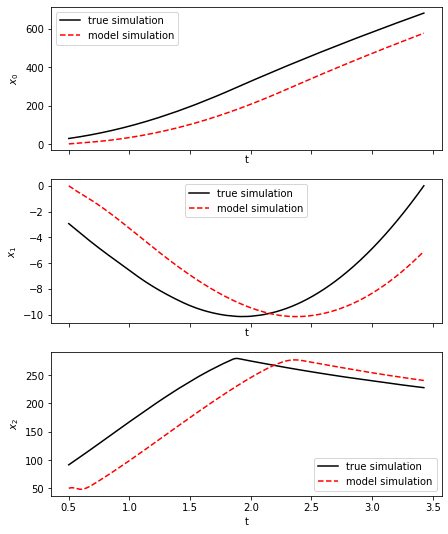

In [44]:
#pruebo con valores raros:
plot_aprox_real(var.T[500:, 1:4], var.T[500:, 0], model, [0, 0, 50])
#se puede ver que sigue la curva pero retrasado en el tiempo

Model score: -825510.210690
Model score: -836882.609202


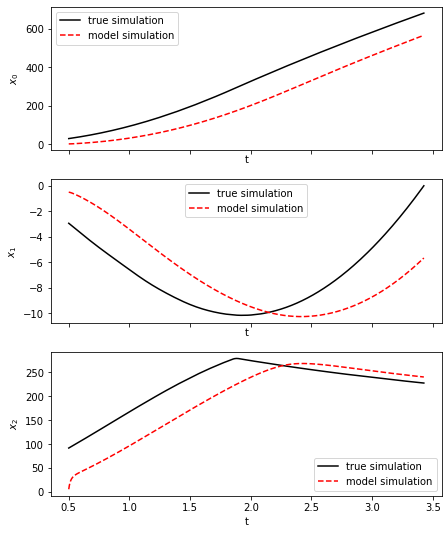

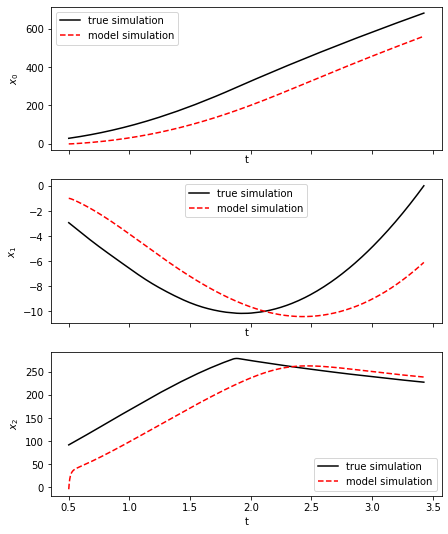

In [45]:
#pruebo con mas valores raros:
plot_aprox_real(var.T[500:, 1:4], var.T[500:, 0], model, [0.5, -0.5, 5])
plot_aprox_real(var.T[500:, 1:4], var.T[500:, 0], model, [-1, -1, -5])

In [46]:
print(var.T[2, 0])

0.002


#### Prueba 2: Pruebo con las derivadas de x,y, v

Obtengo el array: x,y,v, alpha, theta, theta', x' e y'

In [47]:
var5 = np.loadtxt('vars5.csv', delimiter=",")
der5 = np.loadtxt('ders5.csv', delimiter=",")

der_var = np.loadtxt('der_var1.csv', delimiter=",")

In [48]:
print(var5.shape, der_var.shape)

(9, 3427) (7, 3427)


In [49]:
a = np.concatenate((var5.T[1:, 1:4], der5.T[1:, 1:4]))
print(der_var.T[1:, 1:], var5.T[1:, 1:4], der5.T[1:, 1:4])


[[ 2.4782e-02  3.7046e-03  2.5116e+01  2.4840e+01  3.7084e+00  1.1560e+02]
 [ 4.9681e-02  7.4167e-03  2.5231e+01  2.4956e+01  3.7159e+00  1.1568e+02]
 [ 7.4695e-02  1.1136e-02  2.5347e+01  2.5072e+01  3.7235e+00  1.1576e+02]
 ...
 [ 6.8149e+02  2.4342e-02  2.2756e+02  2.2718e+02 -1.3196e+01 -2.6291e+01]
 [ 6.8172e+02  1.1141e-02  2.2754e+02  2.2715e+02 -1.3205e+01 -2.6284e+01]
 [ 6.8195e+02 -2.0674e-03  2.2751e+02  2.2713e+02 -1.3213e+01 -2.6277e+01]] [[ 2.4782e-02 -3.7046e-03  2.5116e+01]
 [ 4.9681e-02 -7.4167e-03  2.5231e+01]
 [ 7.4695e-02 -1.1136e-02  2.5347e+01]
 ...
 [ 6.8149e+02 -2.4342e-02  2.2756e+02]
 [ 6.8172e+02 -1.1141e-02  2.2754e+02]
 [ 6.8195e+02  2.0674e-03  2.2751e+02]] [[ 24.84     3.7084 115.6   ]
 [ 24.956    3.7159 115.68  ]
 [ 25.072    3.7235 115.76  ]
 ...
 [227.18   -13.196  -26.291 ]
 [227.15   -13.205  -26.284 ]
 [227.13   -13.213  -26.277 ]]


In [50]:
# Configuro las restricciones:
#cols = np.concatenate((np.arange(0, 4), np.arange(7,9)))
n_targets = der_var.T[1:, 1:].shape[1]
constraint_rhs = np.array([1])
library = ps.PolynomialLibrary(degree=3)

library.fit(der_var.T[1:, 1:])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

Features (84): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x3^2', 'x3 x4', 'x3 x5', 'x4^2', 'x4 x5', 'x5^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0^2 x3', 'x0^2 x4', 'x0^2 x5', 'x0 x1^2', 'x0 x1 x2', 'x0 x1 x3', 'x0 x1 x4', 'x0 x1 x5', 'x0 x2^2', 'x0 x2 x3', 'x0 x2 x4', 'x0 x2 x5', 'x0 x3^2', 'x0 x3 x4', 'x0 x3 x5', 'x0 x4^2', 'x0 x4 x5', 'x0 x5^2', 'x1^3', 'x1^2 x2', 'x1^2 x3', 'x1^2 x4', 'x1^2 x5', 'x1 x2^2', 'x1 x2 x3', 'x1 x2 x4', 'x1 x2 x5', 'x1 x3^2', 'x1 x3 x4', 'x1 x3 x5', 'x1 x4^2', 'x1 x4 x5', 'x1 x5^2', 'x2^3', 'x2^2 x3', 'x2^2 x4', 'x2^2 x5', 'x2 x3^2', 'x2 x3 x4', 'x2 x3 x5', 'x2 x4^2', 'x2 x4 x5', 'x2 x5^2', 'x3^3', 'x3^2 x4', 'x3^2 x5', 'x3 x4^2', 'x3 x4 x5', 'x3 x5^2', 'x4^3', 'x4^2 x5', 'x4 x5^2', 'x5^3']


In [51]:
# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((1, n_targets * n_features))

# 0 * (x0 coefficient) + 0*(x0 coefficient)...+1*(x3 coefficient)) = 1
for i in np.arange(n_features):
    constraint_lhs[0, i] = 0
constraint_lhs[0, 4] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model3 = ps.deeptime.SINDyEstimator(optimizer=optimizer, 
                  feature_library=library,
                  feature_names=['x', 'y', 'v', "x'", "y'", "v'"]
                 ).fit(der_var.T[1:, 1:], t=der_var.T[1,0])
model3.print()

x' = 142978581108174569472.000 1 + 1927265801207425007616.000 x + -243444614314847698944.000 y + 2818066938872525225984.000 v + -254400.370 x' + -29981397677835931648.000 y' + 10481625409937194614784.000 v' + -3866462654085395382272.000 x^2 + -19837490740732968828928.000 x y + 78986502037103850815488.000 x v + -68308712335739910619136.000 x x' + -9322958524977672880128.000 x y' + -6778590322303021613056.000 x v' + 1694956668374418718720.000 y^2 + 2046254252109197213696.000 y v + 19754605469275697184768.000 y x' + -939800853215579996160.000 y y' + -28679384558233047793664.000 y v' + 181942715552104565440512.000 v^2 + -105021736025287366279168.000 v x' + -19422465877212655517696.000 v y' + 36424140195443209404416.000 v v' + -85531321998752593477632.000 x'^2 + -17506097373042058461184.000 x' y' + -25587504691813107630080.000 x' v' + -2609012313435721433088.000 y'^2 + -17150597081770502389760.000 y' v' + -1573386983770354352128.000 v'^2 + 17696806016628643840.000 x^3 + -7152727860320678707

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/constrained_sr3.py:296: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


In [52]:
#como saco v''???
lib = ps.PolynomialLibrary(degree=3)
#cols = np.concatenate((np.arange(1, 4), np.arange(7,9)))
model2 = sindy_deeptime(lib, der_var.T[1:, 1:], ['x', 'y', 'v', "x'", "y'", "v'"])


LinAlgError: 69-th leading minor of the array is not positive definite

In [53]:
#celda aleatoria, saca lo que quiere, el plot hace demasiado trabajo
#pruebo valores qeu ya se encuentran en la matriz: funciona bien

#hace bastante bien la aproximación excepto de x' e y'
plot_aprox_real(var5.T[1:, cols], var5.T[1:, 0], model2, var5.T[1, cols])

NameError: name 'cols' is not defined

Pruebo valores extraños que no se encuentran en datos de entrenamiento

In [ ]:
print(cols)
#print('Model score: %f' % model2.score(np.array([0, 0, 50, 0.01, 0.01]), t=paso_tiempo))
plot_aprox_real(var5.T[1:, cols], var5.T[1:, 0], model2, [0.1, 0.1, 25, 0.01, 0.01])


#### Prueba3: Incluyo el tiempo en la prueba anterior e impongo restricciones en el optimizador

In [ ]:
# Configuro las restricciones:
cols = np.concatenate((np.arange(0, 4), np.arange(7,9)))
n_targets = der_var.T[1:, :].shape[1]
constraint_rhs = np.array([1])
library = ps.PolynomialLibrary(degree=3)

library.fit(der_var.T[1:, :])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

In [ ]:
# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((1, n_targets * n_features))

# 1 * (x0 coefficient) = 1
constraint_lhs[0, 0] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model3 = ps.deeptime.SINDyEstimator(optimizer=optimizer, 
                  feature_library=library,
                  feature_names=['t','x', 'y', 'v', "x'", "y'", "v'"]
                 ).fit(der_var.T[1:, :], t=der_var.T[1,0])
model3.print()


In [ ]:
plot_aprox_real(var5.T[1:, cols2], var5.T[1:, 0], model3, var5.T[1, cols2])

In [ ]:
# prueba con valores que no están en la matriz de train
plot_aprox_real(var5.T[1:, cols2], var5.T[1:, 0], model3, [0.008, 0.1, 0.2, 60, 0.001, 0.002])

#### Prueba 4: Trayecotrias simples:

#### Prueba 5: Predecir con v,  alpha , theta y theta'

In [54]:
print(var.T.shape, der.T.shape)

(3427, 7) (3427, 7)


In [55]:
var.T[1:, 2:7]

array([[-3.7046e-03,  2.5116e+01,  3.8584e-04,  1.4858e-01, -3.3290e-05],
       [-7.4167e-03,  2.5231e+01,  7.6805e-04,  1.4858e-01, -6.8620e-05],
       [-1.1136e-02,  2.5347e+01,  1.1467e-03,  1.4858e-01, -1.0601e-04],
       ...,
       [-2.4342e-02,  2.2756e+02,  2.1785e-04, -5.7805e-02, -4.2074e-02],
       [-1.1141e-02,  2.2754e+02,  2.1843e-04, -5.7847e-02, -4.2084e-02],
       [ 2.0674e-03,  2.2751e+02,  2.1900e-04, -5.7889e-02, -4.2093e-02]])

In [56]:
lib = ps.PolynomialLibrary(degree=2)+ps.FourierLibrary()
#cols = np.concatenate((np.arange(1, 4), np.arange(7,9)))
model2 = sindy_deeptime(lib, var.T[1:, 3:7], ['v', 'alpha', 'theta', "theta'"])

v' = 1884334205.794 1 + -10.372 v + -2153406.805 alpha + 9658521.102 theta + 11084.842 theta' + 0.018 v^2 + 60.752 v alpha + 162.530 v theta + 2.624 v theta' + -855360211.660 alpha^2 + 40248.234 alpha theta + -294.296 alpha theta' + -86962460.767 theta^2 + 17209.063 theta theta' + 319746.461 theta'^2 + -0.483 sin(1 v) + 2138767.615 sin(1 alpha) + -1710877519.523 cos(1 alpha) + -9694436.844 sin(1 theta) + -174091513.117 cos(1 theta) + -11914.130 sin(1 theta') + 636336.919 cos(1 theta')
alpha' = -419801.972 1 + 4527.052 alpha + 541.359 theta + -14.535 theta' + 215078.871 alpha^2 + -32.370 alpha theta + 0.766 alpha theta' + -5127.526 theta^2 + 0.406 theta theta' + -108.198 theta'^2 + -4529.367 sin(1 alpha) + 430293.084 cos(1 alpha) + -541.205 sin(1 theta) + -10276.082 cos(1 theta) + 15.472 sin(1 theta') + -214.994 cos(1 theta')
theta' = 3705.734 1 + 29.927 alpha + -0.053 theta + 1.036 theta' + -1854.897 alpha^2 + -0.036 alpha theta + 1.940 theta^2 + 0.190 theta'^2 + -29.925 sin(1 alpha) +

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/sr3.py:265: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


In [57]:
# Configuro las restricciones:
#cols = np.concatenate((np.arange(0, 4), np.arange(7,9)))
n_targets = var.T[1:, 3:7].shape[1]
constraint_rhs = np.array([1])
library = ps.PolynomialLibrary(degree=2)+ps.FourierLibrary()

library.fit(var.T[1:, 3:7])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

Features (23): ['1', 'x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2', 'sin(1 x0)', 'cos(1 x0)', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'sin(1 x3)', 'cos(1 x3)']


In [58]:
# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((1, n_targets * n_features))

# 0 * (x0 coefficient) + 0*(x0 coefficient)...+1*(x3 coefficient)) = 1
#for i in np.arange(n_features):
#    constraint_lhs[0, i] = 0

for i in np.arange(n_features):
    constraint_lhs[0, i + 2*n_features] = 0
constraint_lhs[0, 3 + 2*n_features] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model5 = ps.deeptime.SINDyEstimator(optimizer=optimizer, 
                  feature_library=library,
                  feature_names=['v', 'alpha', 'theta', "theta'"]
                 ).fit(var.T[1:, 3:7], t=var.T[1,0])
model5.print()

v' = 2900070.614 1 + -30.510 v + -36420031.550 alpha + 7654827.118 theta + 32133.247 theta' + -241.235 v alpha + 218.393 v theta + -21.512 v theta' + 1343131.354 alpha^2 + -522148.207 alpha theta + 50237.721 alpha theta' + -2572413.039 theta^2 + -55591.531 theta theta' + 251566.308 theta'^2 + -0.738 sin(1 v) + 36493790.470 sin(1 alpha) + 1704818.234 cos(1 alpha) + -7708744.843 sin(1 theta) + -5102439.763 cos(1 theta) + -26244.854 sin(1 theta') + 501993.578 cos(1 theta')
alpha' = -126.911 1 + 1689.719 alpha + 159.275 theta + 1.499 theta' + -11.616 alpha^2 + -81.896 alpha theta + -3.997 alpha theta' + 131.385 theta^2 + 2.911 theta theta' + -12.992 theta'^2 + -1686.193 sin(1 alpha) + -96.880 cos(1 alpha) + -157.756 sin(1 theta) + 249.417 cos(1 theta) + -0.796 sin(1 theta') + -25.705 cos(1 theta')
theta' = 2.585 1 + -28.100 alpha + 1.000 theta + 0.997 theta' + 1.280 alpha^2 + -0.273 alpha theta + -1.901 theta^2 + -0.195 theta'^2 + 28.012 sin(1 alpha) + 1.542 cos(1 alpha) + -0.821 sin(1 the

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/constrained_sr3.py:296: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


#### Prueba6: initial guess, librería personalizada y usando v, , alpha, theta y theta'

In [13]:
var6 = np.loadtxt('vars6.csv', delimiter=",")
print(var6.T[1,0])

0.001


In [14]:
lib = custom_library2().fit(var6.T[1:, 3:7])
n_features = lib.n_output_features_
print(f"Features ({n_features}):", lib.get_feature_names(['alpha', 'theta', "theta'", 'v']))
lib.functions

Features (56): ['cos(alpha-theta)', "cos(alpha-theta')", 'cos(alpha-v)', "cos(theta-theta')", 'cos(theta-v)', "cos(theta'-v)", "cos(alpha-theta)/theta'", 'cos(alpha-theta)/v', "cos(alpha-theta')/v", "cos(theta-theta')/v", 'sen(alpha-theta)', "sen(alpha-theta')", 'sen(alpha-v)', "sen(theta-theta')", 'sen(theta-v)', "sen(theta'-v)", 'sen(alpha)', 'sen(theta)', "sen(theta')", 'sen(v)', 'sen(alpha)/theta', "sen(alpha)/theta'", 'sen(alpha)/v', "sen(theta)/theta'", 'sen(theta)/v', "sen(theta')/v", 'cos(alpha)', 'cos(theta)', "cos(theta')", 'cos(v)', 'theta*alpha^2', "theta'*alpha^2", 'v*alpha^2', "theta'*theta^2", 'v*theta^2', "v*theta'^2", 'alpha*theta^2', "alpha*theta'^2", 'alpha*v^2', "theta*theta'^2", 'theta*v^2', "theta'*v^2", 'theta*alpha', "theta'*alpha", 'v*alpha', "theta'*theta", 'v*theta', "v*theta'", 'alpha^2', 'theta^2', "theta'^2", 'v^2', 'alpha', 'theta', "theta'", 'v']


[<function __main__.custom_library2.<locals>.<lambda>(theta, alfa)>,
 <function __main__.custom_library2.<locals>.<lambda>(theta, alfa, v)>,
 <function __main__.custom_library2.<locals>.<lambda>(theta, alfa)>,
 <function __main__.custom_library2.<locals>.<lambda>(alfa)>,
 <function __main__.custom_library2.<locals>.<lambda>(alfa, v)>,
 <function __main__.custom_library2.<locals>.<lambda>(alfa)>,
 <function __main__.custom_library2.<locals>.<lambda>(v, alfa)>,
 <function __main__.custom_library2.<locals>.<lambda>(v, alfa)>,
 <function __main__.custom_library2.<locals>.<lambda>(v, alfa)>,
 <function __main__.custom_library2.<locals>.<lambda>(v)>,
 <function __main__.custom_library2.<locals>.<lambda>(theta)>]

In [15]:
model6 = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        optimizer=ps.SR3(),
        feature_library=custom_library2(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['alpha', 'theta', "theta'", 'v'], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

#la doc dice que en t hay que poner el time step
model6.fit(var6.T[1:, 3:7], t=var6.T[1,0])

#print(model.equations(precision=52))
model6.print(precision=4)

alpha' = 1449.2009 cos(alpha-theta) + -551.9848 cos(alpha-theta') + 438.1562 cos(theta-theta') + -563.6667 cos(alpha-theta)/v + -332.2452 cos(alpha-theta')/v + 907.4893 cos(theta-theta')/v + -536128.2666 sen(alpha-theta) + 1128.4757 sen(alpha-theta') + 183.2741 sen(theta-theta') + 514918.0561 sen(alpha) + -536089.3553 sen(theta) + 1312.4095 sen(theta') + 502.7647 sen(alpha)/v + 79.9434 sen(theta)/v + 6.6780 sen(theta')/v + 3805.2174 cos(alpha) + -5239.7687 cos(theta) + 99.1719 cos(theta') + 265947.9282 theta*alpha^2 + -1211.2703 theta'*alpha^2 + -2.1916 v*alpha^2 + -131.5967 theta'*theta^2 + 0.0244 v*theta^2 + -267999.1763 alpha*theta^2 + 550.6593 alpha*theta'^2 + 105.5852 theta*theta'^2 + -1461.5481 theta*alpha + 554.9855 theta'*alpha + -440.9577 theta'*theta + 2798.7107 alpha^2 + -1683.9649 theta^2 + -6.8580 theta'^2 + 20077.3387 alpha + -222.4770 theta + 0.2741 theta'
theta' = -444.8310 cos(alpha-theta) + -9.2904 cos(alpha-theta') + 13.7299 cos(theta-theta') + -5.8883 cos(alpha-thet

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/sr3.py:265: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


In [31]:
print(model6.coefficients(), model6.coefficients().shape, model6.get_feature_names())


[[ 1.44920088e+03 -5.51984827e+02  0.00000000e+00  4.38156209e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.63666676e+02
  -3.32245187e+02  9.07489308e+02 -5.36128267e+05  1.12847574e+03
   0.00000000e+00  1.83274077e+02  0.00000000e+00  0.00000000e+00
   5.14918056e+05 -5.36089355e+05  1.31240950e+03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.02764710e+02  0.00000000e+00
   7.99433880e+01  6.67801811e+00  3.80521739e+03 -5.23976872e+03
   9.91719333e+01  0.00000000e+00  2.65947928e+05 -1.21127028e+03
  -2.19163534e+00 -1.31596745e+02  2.44239611e-02  0.00000000e+00
  -2.67999176e+05  5.50659263e+02  0.00000000e+00  1.05585168e+02
   0.00000000e+00  0.00000000e+00 -1.46154811e+03  5.54985467e+02
   0.00000000e+00 -4.40957656e+02  0.00000000e+00  0.00000000e+00
   2.79871073e+03 -1.68396487e+03 -6.85803707e+00  0.00000000e+00
   2.00773387e+04 -2.22477000e+02  2.74050087e-01  0.00000000e+00]
 [-4.44830962e+02 -9.29041042e+00  0.00000000e+00  1.37298640e+01
   0.0000

In [16]:
def search_index(s, sett):
    cont = 0
    for i in sett:
        if i == s:
            return cont
        cont = cont + 1

In [17]:
index = search_index("theta'", model6.get_feature_names())
index

54

In [28]:
def return_initial_guess(data, lenght):
    initial_guess = np.zeros((lenght[0], lenght[1]))

    lib = custom_library2().fit(data)
    functions = lib.get_feature_names(['alpha', 'theta', "theta'", 'v'])


    #ecuacion de alpha
    initial_guess[0, functions.index("theta'")]= 1. #D*theta'
    initial_guess[0, functions.index("v*alpha")] = -1. #E *V *alpha
    initial_guess[0, functions.index("sen(alpha)/v")] = -1. # F/v * sen alpha
    initial_guess[0, functions.index("cos(alpha-theta)/v")] = 1. # G/V * cos(theta-alpha)
    #ecuacion de theta'
    initial_guess[1, functions.index("theta'")] = 1. #theta'
    #ecuacion de theta''
    initial_guess[2, functions.index("alpha*v^2")] = 1. # alpha*v²
    initial_guess[2, functions.index("v*theta'")] = 1. #v*theta'
    initial_guess[2, functions.index("sen(alpha)")] = -1. # sen(alpha) 
    initial_guess[2, functions.index("cos(alpha-theta)")] = 1.#cos(theta-alpha)
    #ecuaciones de v
    initial_guess[3, functions.index("cos(alpha)")] = 1. #cos(alpha)
    initial_guess[3, functions.index("v^2")]= -1 #v²
    initial_guess[3, functions.index("sen(alpha-theta)")] = 1. #sen(theta-alpha)
    
    return initial_guess

In [29]:
initial_guess = return_initial_guess(var6.T[1:, 3:7], model6.coefficients().shape)
model6_1 = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        optimizer=ps.SR3(initial_guess=initial_guess),
        feature_library=custom_library2(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['alpha', 'theta', "theta'", 'v'], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

#la doc dice que en t hay que poner el time step
model6.fit(var6.T[1:, 3:7], t=var6.T[1,0])

#print(model.equations(precision=52))
model6.print(precision=4)

alpha' = 1449.2009 cos(alpha-theta) + -551.9848 cos(alpha-theta') + 438.1562 cos(theta-theta') + -563.6667 cos(alpha-theta)/v + -332.2452 cos(alpha-theta')/v + 907.4893 cos(theta-theta')/v + -536128.2666 sen(alpha-theta) + 1128.4757 sen(alpha-theta') + 183.2741 sen(theta-theta') + 514918.0561 sen(alpha) + -536089.3553 sen(theta) + 1312.4095 sen(theta') + 502.7647 sen(alpha)/v + 79.9434 sen(theta)/v + 6.6780 sen(theta')/v + 3805.2174 cos(alpha) + -5239.7687 cos(theta) + 99.1719 cos(theta') + 265947.9282 theta*alpha^2 + -1211.2703 theta'*alpha^2 + -2.1916 v*alpha^2 + -131.5967 theta'*theta^2 + 0.0244 v*theta^2 + -267999.1763 alpha*theta^2 + 550.6593 alpha*theta'^2 + 105.5852 theta*theta'^2 + -1461.5481 theta*alpha + 554.9855 theta'*alpha + -440.9577 theta'*theta + 2798.7107 alpha^2 + -1683.9649 theta^2 + -6.8580 theta'^2 + 20077.3387 alpha + -222.4770 theta + 0.2741 theta'
theta' = -444.8310 cos(alpha-theta) + -9.2904 cos(alpha-theta') + 13.7299 cos(theta-theta') + -5.8883 cos(alpha-thet

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/sr3.py:265: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


Con el solver de raul no van bien los resultados, probar con valores generados por solve_ivp sinteticos

### Prueba 7: haciendo el caso anterior pero con valores de solve_ivp

0.0 29.999000000000002
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19232
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.9997e+01, 2.9998e+01,
       2.9999e+01])
 t_events: None
        y: array([[ 1.39626340e-01,  1.38780259e-01,  1.37946151e-01, ...,
         6.80518475e-05,  1.02815887e-04,  1.36019590e-04],
       [ 1.39626340e-01,  1.39626209e-01,  1.39625614e-01, ...,
        -8.20032158e-02, -8.19712946e-02, -8.19409286e-02],
       [ 1.00000000e-04, -3.62177417e-04, -8.28420197e-04, ...,
         3.25032143e-02,  3.12098891e-02,  2.94070626e-02],
       [ 5.00000000e+01,  5.03730129e+01,  5.07460602e+01, ...,
         3.37922174e+03,  3.37922370e+03,  3.37922566e+03]])
 y_events: None


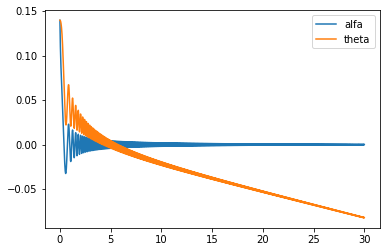

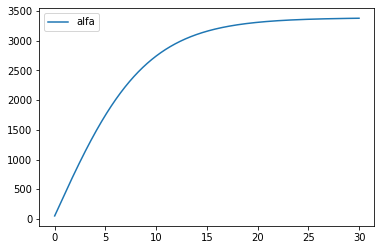

30000 (30000, 4)
[[ 1.39626340e-01  1.39626340e-01  1.00000000e-04  5.00000000e+01]
 [ 1.38780259e-01  1.39626209e-01 -3.62177417e-04  5.03730129e+01]
 [ 1.37946151e-01  1.39625614e-01 -8.28420197e-04  5.07460602e+01]
 ...
 [ 6.80518475e-05 -8.20032158e-02  3.25032143e-02  3.37922174e+03]
 [ 1.02815887e-04 -8.19712946e-02  3.12098891e-02  3.37922370e+03]
 [ 1.36019590e-04 -8.19409286e-02  2.94070626e-02  3.37922566e+03]]
(30000, 4)


In [30]:
x_train, x_dot_train = calculate_data(max_time, paso_tiempo, coefs, inicial_values)
print(x_train)
print(x_train.shape)

In [31]:
initial_guess = return_initial_guess(x_train, model6.coefficients().shape)
model7 = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        optimizer=ps.SR3(initial_guess=initial_guess),
        feature_library=custom_library2(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['alpha', 'theta', "theta'", 'v'], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

#la doc dice que en t hay que poner el time step
model6.fit(var6.T[1:, 3:7], t=var6.T[1,0])

#print(model.equations(precision=52))
model6.print(precision=4)

alpha' = 1449.2009 cos(alpha-theta) + -551.9848 cos(alpha-theta') + 438.1562 cos(theta-theta') + -563.6667 cos(alpha-theta)/v + -332.2452 cos(alpha-theta')/v + 907.4893 cos(theta-theta')/v + -536128.2666 sen(alpha-theta) + 1128.4757 sen(alpha-theta') + 183.2741 sen(theta-theta') + 514918.0561 sen(alpha) + -536089.3553 sen(theta) + 1312.4095 sen(theta') + 502.7647 sen(alpha)/v + 79.9434 sen(theta)/v + 6.6780 sen(theta')/v + 3805.2174 cos(alpha) + -5239.7687 cos(theta) + 99.1719 cos(theta') + 265947.9282 theta*alpha^2 + -1211.2703 theta'*alpha^2 + -2.1916 v*alpha^2 + -131.5967 theta'*theta^2 + 0.0244 v*theta^2 + -267999.1763 alpha*theta^2 + 550.6593 alpha*theta'^2 + 105.5852 theta*theta'^2 + -1461.5481 theta*alpha + 554.9855 theta'*alpha + -440.9577 theta'*theta + 2798.7107 alpha^2 + -1683.9649 theta^2 + -6.8580 theta'^2 + 20077.3387 alpha + -222.4770 theta + 0.2741 theta'
theta' = -444.8310 cos(alpha-theta) + -9.2904 cos(alpha-theta') + 13.7299 cos(theta-theta') + -5.8883 cos(alpha-thet

/usr/local/lib/python3.8/dist-packages/pysindy/optimizers/sr3.py:265: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
